# Image

In [10]:
from __future__ import print_function
"""
get_image_size.py
====================
    :Name:        get_image_size
    :Purpose:     extract image dimensions given a file path
    :Author:      Paulo Scardine (based on code from Emmanuel VAÏSSE)
    :Created:     26/09/2013
    :Copyright:   (c) Paulo Scardine 2013
    :Licence:     MIT
"""

import collections
import json
import os
import io
import struct

FILE_UNKNOWN = "Sorry, don't know how to get size for this file."


class UnknownImageFormat(Exception):
    pass


types = collections.OrderedDict()
BMP = types['BMP'] = 'BMP'
GIF = types['GIF'] = 'GIF'
ICO = types['ICO'] = 'ICO'
JPEG = types['JPEG'] = 'JPEG'
PNG = types['PNG'] = 'PNG'
TIFF = types['TIFF'] = 'TIFF'

image_fields = ['path', 'type', 'file_size', 'width', 'height']


class Image(collections.namedtuple('Image', image_fields)):

    def to_str_row(self):
        return ("%d\t%d\t%d\t%s\t%s" % (
            self.width,
            self.height,
            self.file_size,
            self.type,
            self.path.replace('\t', '\\t'),
        ))

    def to_str_row_verbose(self):
        return ("%d\t%d\t%d\t%s\t%s\t##%s" % (
            self.width,
            self.height,
            self.file_size,
            self.type,
            self.path.replace('\t', '\\t'),
            self))

    def to_str_json(self, indent=None):
        return json.dumps(self._asdict(), indent=indent)


def get_image_size(file_path):
    """
    Return (width, height) for a given img file content - no external
    dependencies except the os and struct builtin modules
    """
    img = get_image_metadata(file_path)
    return (img.width, img.height)


def get_image_size_from_bytesio(input, size):
    """
    Return (width, height) for a given img file content - no external
    dependencies except the os and struct builtin modules
    Args:
        input (io.IOBase): io object support read & seek
        size (int): size of buffer in byte
    """
    img = get_image_metadata_from_bytesio(input, size)
    return (img.width, img.height)


def get_image_metadata(file_path):
    """
    Return an `Image` object for a given img file content - no external
    dependencies except the os and struct builtin modules
    Args:
        file_path (str): path to an image file
    Returns:
        Image: (path, type, file_size, width, height)
    """
    size = os.path.getsize(file_path)

    # be explicit with open arguments - we need binary mode
    with io.open(file_path, "rb") as input:
        return get_image_metadata_from_bytesio(input, size, file_path)


def get_image_metadata_from_bytesio(input, size, file_path=None):
    """
    Return an `Image` object for a given img file content - no external
    dependencies except the os and struct builtin modules
    Args:
        input (io.IOBase): io object support read & seek
        size (int): size of buffer in byte
        file_path (str): path to an image file
    Returns:
        Image: (path, type, file_size, width, height)
    """
    height = -1
    width = -1
    data = input.read(26)
    msg = " raised while trying to decode as JPEG."

    if (size >= 10) and data[:6] in (b'GIF87a', b'GIF89a'):
        # GIFs
        imgtype = GIF
        w, h = struct.unpack("<HH", data[6:10])
        width = int(w)
        height = int(h)
    elif ((size >= 24) and data.startswith(b'\211PNG\r\n\032\n')
            and (data[12:16] == b'IHDR')):
        # PNGs
        imgtype = PNG
        w, h = struct.unpack(">LL", data[16:24])
        width = int(w)
        height = int(h)
    elif (size >= 16) and data.startswith(b'\211PNG\r\n\032\n'):
        # older PNGs
        imgtype = PNG
        w, h = struct.unpack(">LL", data[8:16])
        width = int(w)
        height = int(h)
    elif (size >= 2) and data.startswith(b'\377\330'):
        # JPEG
        imgtype = JPEG
        input.seek(0)
        input.read(2)
        b = input.read(1)
        try:
            while (b and ord(b) != 0xDA):
                while (ord(b) != 0xFF):
                    b = input.read(1)
                while (ord(b) == 0xFF):
                    b = input.read(1)
                if (ord(b) >= 0xC0 and ord(b) <= 0xC3):
                    input.read(3)
                    h, w = struct.unpack(">HH", input.read(4))
                    break
                else:
                    input.read(
                        int(struct.unpack(">H", input.read(2))[0]) - 2)
                b = input.read(1)
            width = int(w)
            height = int(h)
        except struct.error:
            raise UnknownImageFormat("StructError" + msg)
        except ValueError:
            raise UnknownImageFormat("ValueError" + msg)
        except Exception as e:
            raise UnknownImageFormat(e.__class__.__name__ + msg)
    elif (size >= 26) and data.startswith(b'BM'):
        # BMP
        imgtype = 'BMP'
        headersize = struct.unpack("<I", data[14:18])[0]
        if headersize == 12:
            w, h = struct.unpack("<HH", data[18:22])
            width = int(w)
            height = int(h)
        elif headersize >= 40:
            w, h = struct.unpack("<ii", data[18:26])
            width = int(w)
            # as h is negative when stored upside down
            height = abs(int(h))
        else:
            raise UnknownImageFormat(
                "Unkown DIB header size:" +
                str(headersize))
    elif (size >= 8) and data[:4] in (b"II\052\000", b"MM\000\052"):
        # Standard TIFF, big- or little-endian
        # BigTIFF and other different but TIFF-like formats are not
        # supported currently
        imgtype = TIFF
        byteOrder = data[:2]
        boChar = ">" if byteOrder == "MM" else "<"
        # maps TIFF type id to size (in bytes)
        # and python format char for struct
        tiffTypes = {
            1: (1, boChar + "B"),  # BYTE
            2: (1, boChar + "c"),  # ASCII
            3: (2, boChar + "H"),  # SHORT
            4: (4, boChar + "L"),  # LONG
            5: (8, boChar + "LL"),  # RATIONAL
            6: (1, boChar + "b"),  # SBYTE
            7: (1, boChar + "c"),  # UNDEFINED
            8: (2, boChar + "h"),  # SSHORT
            9: (4, boChar + "l"),  # SLONG
            10: (8, boChar + "ll"),  # SRATIONAL
            11: (4, boChar + "f"),  # FLOAT
            12: (8, boChar + "d")   # DOUBLE
        }
        ifdOffset = struct.unpack(boChar + "L", data[4:8])[0]
        try:
            countSize = 2
            input.seek(ifdOffset)
            ec = input.read(countSize)
            ifdEntryCount = struct.unpack(boChar + "H", ec)[0]
            # 2 bytes: TagId + 2 bytes: type + 4 bytes: count of values + 4
            # bytes: value offset
            ifdEntrySize = 12
            for i in range(ifdEntryCount):
                entryOffset = ifdOffset + countSize + i * ifdEntrySize
                input.seek(entryOffset)
                tag = input.read(2)
                tag = struct.unpack(boChar + "H", tag)[0]
                if(tag == 256 or tag == 257):
                    # if type indicates that value fits into 4 bytes, value
                    # offset is not an offset but value itself
                    type = input.read(2)
                    type = struct.unpack(boChar + "H", type)[0]
                    if type not in tiffTypes:
                        raise UnknownImageFormat(
                            "Unkown TIFF field type:" +
                            str(type))
                    typeSize = tiffTypes[type][0]
                    typeChar = tiffTypes[type][1]
                    input.seek(entryOffset + 8)
                    value = input.read(typeSize)
                    value = int(struct.unpack(typeChar, value)[0])
                    if tag == 256:
                        width = value
                    else:
                        height = value
                if width > -1 and height > -1:
                    break
        except Exception as e:
            raise UnknownImageFormat(str(e))
    elif size >= 2:
            # see http://en.wikipedia.org/wiki/ICO_(file_format)
        imgtype = 'ICO'
        input.seek(0)
        reserved = input.read(2)
        if 0 != struct.unpack("<H", reserved)[0]:
            raise UnknownImageFormat(FILE_UNKNOWN)
        format = input.read(2)
        assert 1 == struct.unpack("<H", format)[0]
        num = input.read(2)
        num = struct.unpack("<H", num)[0]
        if num > 1:
            import warnings
            warnings.warn("ICO File contains more than one image")
        # http://msdn.microsoft.com/en-us/library/ms997538.aspx
        w = input.read(1)
        h = input.read(1)
        width = ord(w)
        height = ord(h)
    else:
        raise UnknownImageFormat(FILE_UNKNOWN)

    return Image(path=file_path,
                 type=imgtype,
                 file_size=size,
                 width=width,
                 height=height)

In [22]:
import glob
import pandas as pd

In [38]:
## Train set

file_paths = glob.glob('../data/VNOnDB/word/train_word/*.png')
print('Num images: ', len(file_paths))

df = pd.DataFrame(columns=['height', 'width'])
for path in file_paths:
    w, h = get_image_size(path)
    df = df.append({'height': float(h), 'width': float(w)}, ignore_index=True)

print(df.info())
print('\n\nHeight')
print(df.height.describe())
print('\n\nWidth')
print(df.width.describe())

Num images:  66991
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 66991 entries, 0 to 66990
Data columns (total 2 columns):
height    66991 non-null float64
width     66991 non-null float64
dtypes: float64(2)
memory usage: 1.0 MB
None


Height
count    66991.000000
mean        81.229702
std         16.596863
min         19.000000
25%         69.000000
50%         87.000000
75%         96.000000
max         96.000000
Name: height, dtype: float64


Width
count    66991.000000
mean       116.855503
std         18.993342
min         10.000000
25%        111.000000
50%        128.000000
75%        128.000000
max        128.000000
Name: width, dtype: float64


In [39]:
## Validation set

file_paths = glob.glob('../data/VNOnDB/word/validation_word/*.png')
print('Num images: ', len(file_paths))

df = pd.DataFrame(columns=['height', 'width'])
for path in file_paths:
    w, h = get_image_size(path)
    df = df.append({'height': float(h), 'width': float(w)}, ignore_index=True)

print(df.info())
print('\n\nHeight')
print(df.height.describe())
print('\n\nWidth')
print(df.width.describe())

Num images:  18640
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18640 entries, 0 to 18639
Data columns (total 2 columns):
height    18640 non-null float64
width     18640 non-null float64
dtypes: float64(2)
memory usage: 291.4 KB
None


Height
count    18640.000000
mean        80.620815
std         16.746222
min         17.000000
25%         69.000000
50%         86.000000
75%         96.000000
max         96.000000
Name: height, dtype: float64


Width
count    18640.000000
mean       118.000697
std         17.946590
min         22.000000
25%        114.000000
50%        128.000000
75%        128.000000
max        128.000000
Name: width, dtype: float64


In [40]:
## Test set

file_paths = glob.glob('../data/VNOnDB/word/test_word/*.png')
print('Num images: ', len(file_paths))

df = pd.DataFrame(columns=['height', 'width'])
for path in file_paths:
    w, h = get_image_size(path)
    df = df.append({'height': float(h), 'width': float(w)}, ignore_index=True)

print(df.info())
print('\n\nHeight')
print(df.height.describe())
print('\n\nWidth')
print(df.width.describe())

Num images:  25115
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25115 entries, 0 to 25114
Data columns (total 2 columns):
height    25115 non-null float64
width     25115 non-null float64
dtypes: float64(2)
memory usage: 392.5 KB
None


Height
count    25115.000000
mean        81.551901
std         16.428251
min         19.000000
25%         70.000000
50%         87.000000
75%         96.000000
max         96.000000
Name: height, dtype: float64


Width
count    25115.000000
mean       116.564563
std         19.363510
min         11.000000
25%        110.000000
50%        128.000000
75%        128.000000
max        128.000000
Name: width, dtype: float64


# Ground-truth

In [41]:
import glob
from collections import Counter
import pandas as pd
import matplotlib.pyplot as plt

In [42]:
def words_info(f_list):
    df = pd.read_csv(f_list, sep='\t')
    words_list = df.loc[:, 'label'].astype(str)
    words_count = words_list.value_counts()
    words_len = Counter(words_list.str.len().values.astype(int))
    letters_count = Counter(sorted(''.join(words_list)))
    return words_count, letters_count, words_len

In [43]:
def split_letters_counter(all_letters_count):
    upper_chars_cnt, lower_chars_cnt, numbers_cnt = Counter(), Counter(), Counter()
    for letter in all_letters_count.keys():
        if letter.isupper():
            upper_chars_cnt[letter]=all_letters_count[letter]
        elif letter.islower():
            lower_chars_cnt[letter]=all_letters_count[letter]
        else:
            numbers_cnt[letter]=all_letters_count[letter]
    return upper_chars_cnt, lower_chars_cnt, numbers_cnt

In [44]:
def plot_bar(cnt, img_name, is_sorted=False):
    df = pd.DataFrame({"Letter": list(cnt.keys()), "Frequency": list(cnt.values())})
    if is_sorted:
        df= df.sort_values('Frequency', ascending=False)
        
    fig = plt.figure(figsize=(20,10))
    plt.bar('Letter', 'Frequency', data=df)
    plt.xlim(-1,len(df))
    plt.xlabel('Letter', fontsize=15)
    plt.ylabel('Frequency', fontsize=15)
    
    fig.savefig(img_name, dpi=300)

## ALL SET

In [45]:
_, all_letters_cnt, _ = words_info('../data/VNOnDB/word/all_word.csv')

In [46]:
all_upper_chars_cnt, all_lower_chars_cnt, all_numbers_cnt = split_letters_counter(all_letters_cnt)

In [47]:
all_letters_cnt

Counter({'0': 1922,
         '1': 1074,
         '2': 1012,
         '3': 635,
         '4': 314,
         '5': 441,
         '6': 208,
         '7': 225,
         '8': 176,
         '9': 200,
         'A': 280,
         'B': 1008,
         'C': 1627,
         'D': 512,
         'E': 4,
         'F': 1,
         'G': 276,
         'H': 1199,
         'I': 154,
         'J': 17,
         'K': 457,
         'L': 487,
         'M': 531,
         'N': 1929,
         'O': 64,
         'P': 755,
         'Q': 273,
         'R': 65,
         'S': 689,
         'T': 2533,
         'U': 180,
         'V': 1065,
         'W': 16,
         'X': 285,
         'Y': 102,
         'a': 9906,
         'b': 4848,
         'c': 20917,
         'd': 2247,
         'e': 1325,
         'f': 26,
         'g': 20783,
         'h': 31272,
         'i': 20900,
         'j': 18,
         'k': 4359,
         'l': 5881,
         'm': 8665,
         'n': 43466,
         'o': 6707,
         'p': 4409,
         'q':

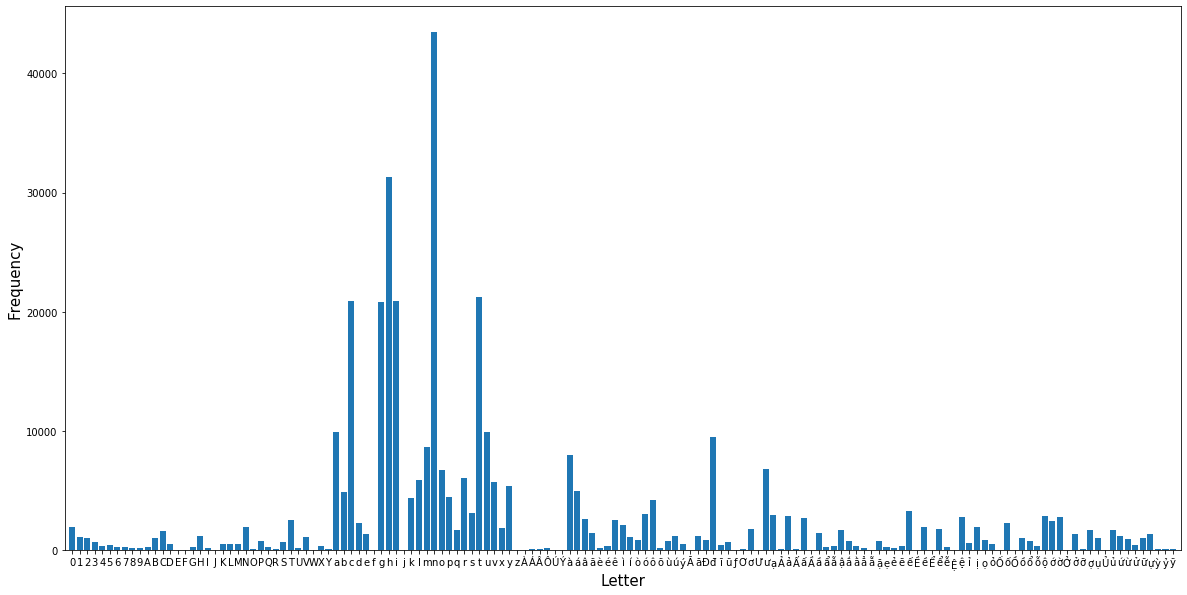

In [48]:
plot_bar(all_letters_cnt, 'word_all/all_letter_frequency.jpg')

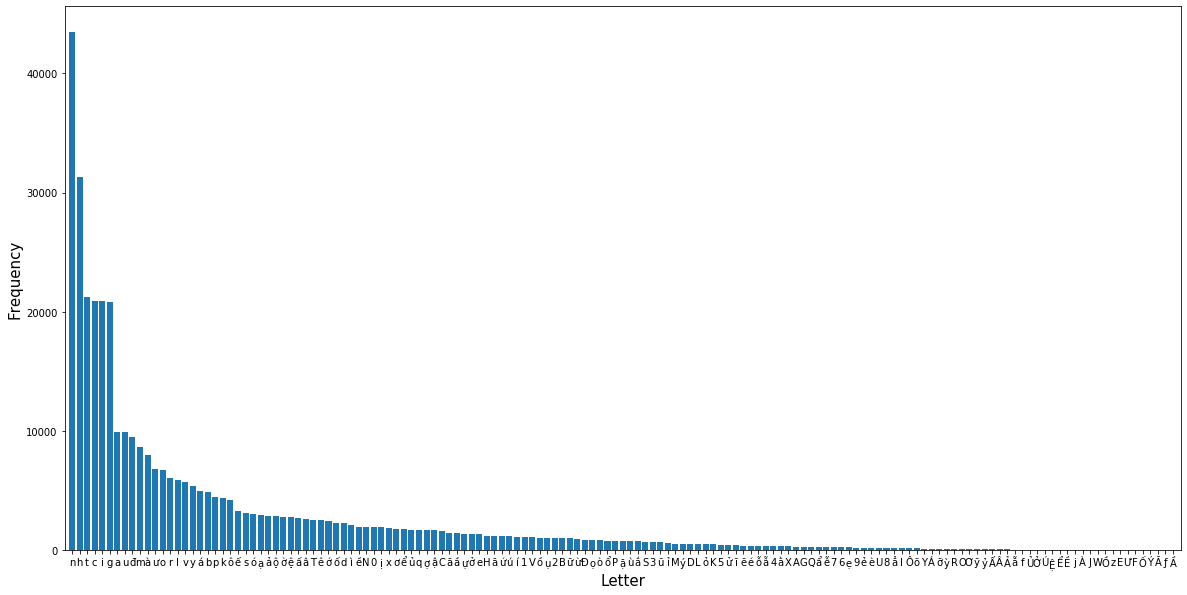

In [49]:
plot_bar(all_letters_cnt,'word_all/all_letter_frequency_sorted.jpg', is_sorted=True)

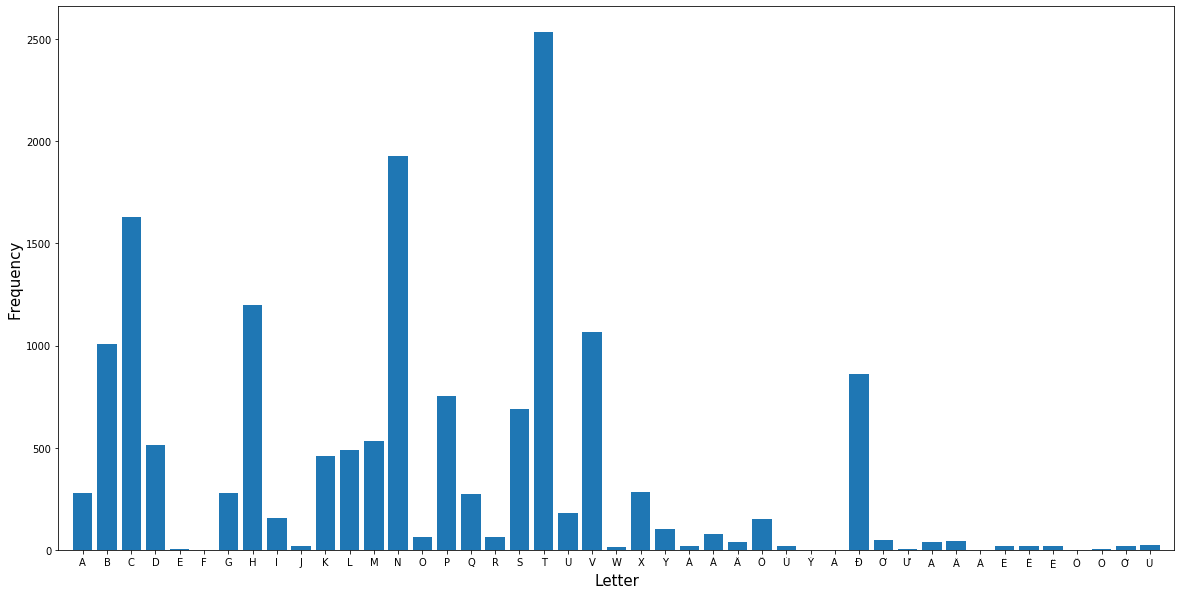

In [50]:
plot_bar(all_upper_chars_cnt, 'word_all/all_upper_characters_frequency.jpg')

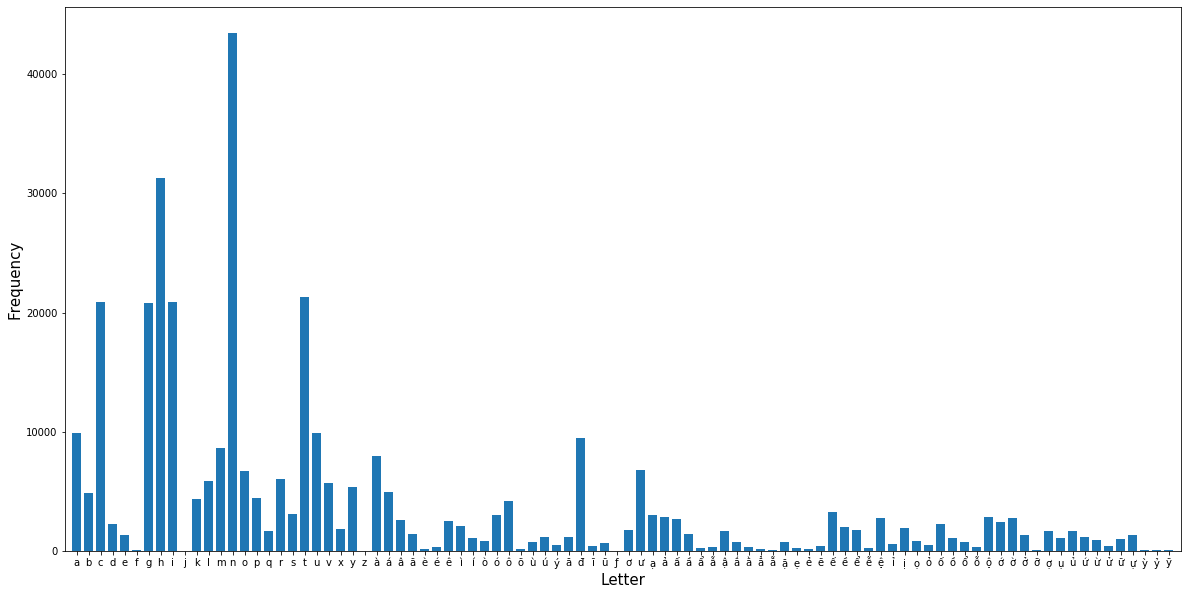

In [51]:
plot_bar(all_lower_chars_cnt, 'word_all/all_lower_characters_frequency.jpg')

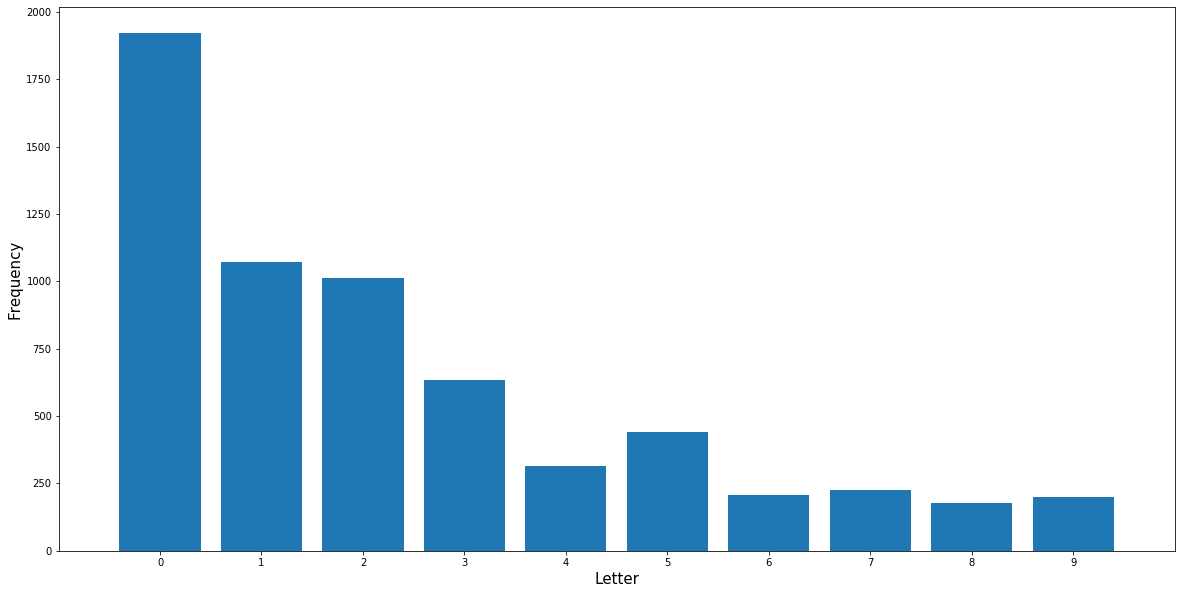

In [52]:
plot_bar(all_numbers_cnt, 'word_all/all_numbers_frequency.jpg')

## TRAIN SET

In [53]:
_, train_letters_cnt, _ = words_info('../data/VNOnDB/word/train_word.csv')

In [54]:
train_upper_chars_cnt, train_lower_chars_cnt, train_numbers_cnt = split_letters_counter(train_letters_cnt)

In [55]:
train_letters_cnt

Counter({'0': 1097,
         '1': 587,
         '2': 612,
         '3': 378,
         '4': 173,
         '5': 266,
         '6': 128,
         '7': 147,
         '8': 110,
         '9': 126,
         'A': 153,
         'B': 585,
         'C': 926,
         'D': 294,
         'E': 2,
         'F': 1,
         'G': 182,
         'H': 715,
         'I': 88,
         'J': 6,
         'K': 266,
         'L': 307,
         'M': 317,
         'N': 1268,
         'O': 41,
         'P': 442,
         'Q': 170,
         'R': 31,
         'S': 399,
         'T': 1505,
         'U': 113,
         'V': 646,
         'W': 13,
         'X': 165,
         'Y': 48,
         'a': 6030,
         'b': 3103,
         'c': 12617,
         'd': 1364,
         'e': 741,
         'f': 11,
         'g': 12180,
         'h': 19102,
         'i': 12595,
         'j': 10,
         'k': 2618,
         'l': 3621,
         'm': 5234,
         'n': 26064,
         'o': 4133,
         'p': 2632,
         'q': 1030,
   

In [56]:
sorted(train_letters_cnt.items(), key=lambda pair: pair[1], reverse=True)

[('n', 26064),
 ('h', 19102),
 ('t', 12946),
 ('c', 12617),
 ('i', 12595),
 ('g', 12180),
 ('a', 6030),
 ('u', 5880),
 ('đ', 5721),
 ('m', 5234),
 ('à', 4998),
 ('o', 4133),
 ('ư', 4048),
 ('l', 3621),
 ('r', 3615),
 ('v', 3531),
 ('y', 3180),
 ('b', 3103),
 ('á', 2864),
 ('p', 2632),
 ('k', 2618),
 ('ô', 2441),
 ('ế', 2029),
 ('ó', 1920),
 ('s', 1898),
 ('ả', 1869),
 ('ạ', 1802),
 ('ộ', 1694),
 ('ờ', 1656),
 ('ệ', 1642),
 ('ớ', 1554),
 ('â', 1551),
 ('ấ', 1525),
 ('T', 1505),
 ('ê', 1425),
 ('d', 1364),
 ('ì', 1337),
 ('ố', 1293),
 ('N', 1268),
 ('ể', 1171),
 ('ề', 1164),
 ('0', 1097),
 ('x', 1087),
 ('ị', 1078),
 ('ủ', 1077),
 ('ậ', 1071),
 ('q', 1030),
 ('ợ', 1018),
 ('ơ', 1015),
 ('C', 926),
 ('ã', 879),
 ('ầ', 878),
 ('ự', 841),
 ('ở', 801),
 ('í', 744),
 ('e', 741),
 ('H', 715),
 ('ứ', 688),
 ('V', 646),
 ('ă', 645),
 ('ú', 644),
 ('2', 612),
 ('ồ', 608),
 ('ữ', 589),
 ('1', 587),
 ('B', 585),
 ('Đ', 585),
 ('ụ', 569),
 ('ọ', 552),
 ('ừ', 486),
 ('ặ', 481),
 ('ắ', 458),
 ('ù', 45

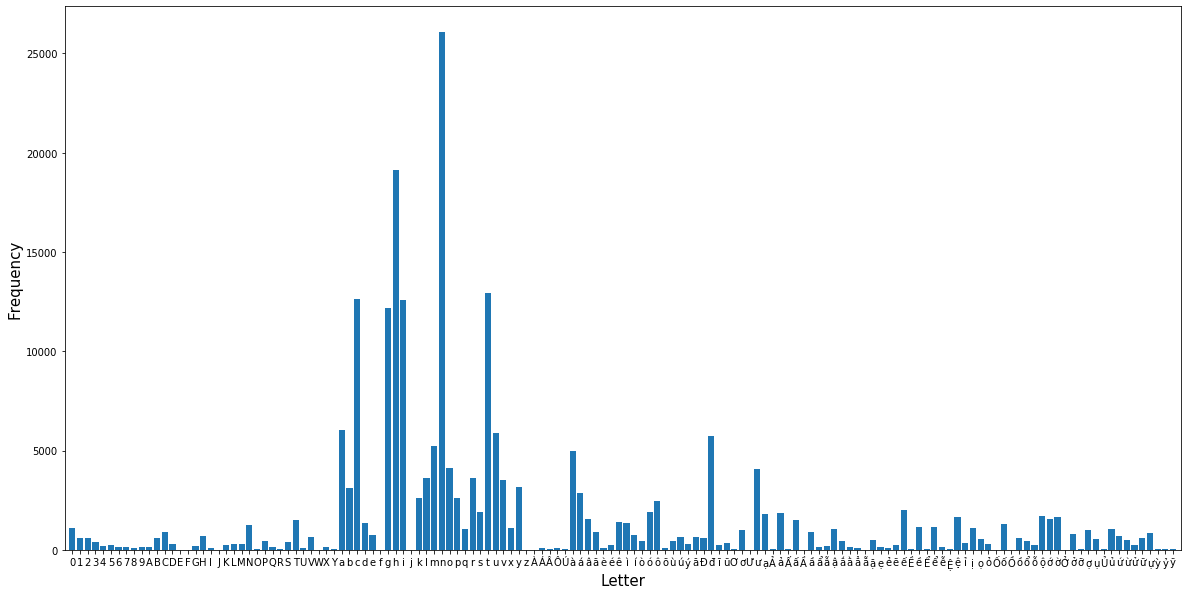

In [57]:
plot_bar(train_letters_cnt, 'word_train/train_letter_frequency.jpg')

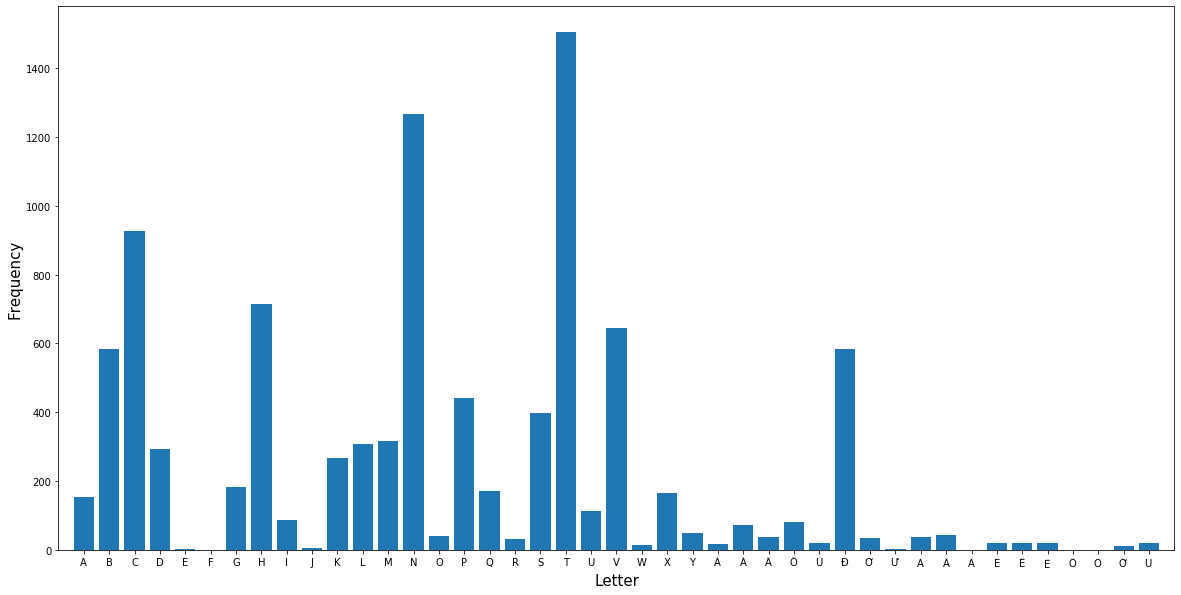

In [58]:
plot_bar(train_upper_chars_cnt, 'word_train/train_upper_characters_frequency.jpg')

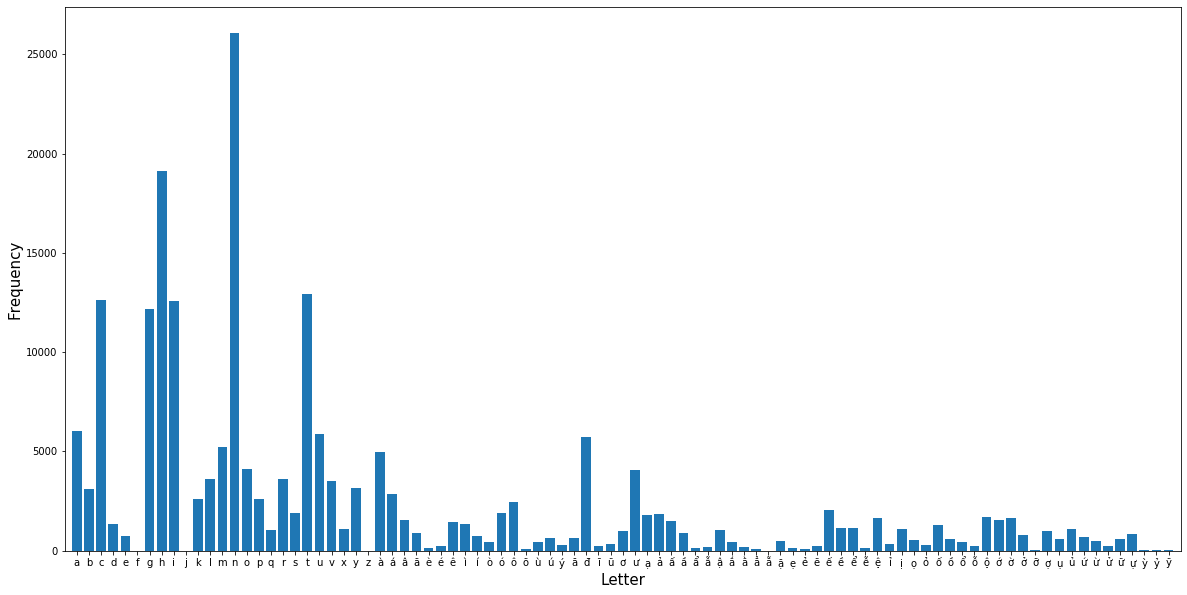

In [59]:
plot_bar(train_lower_chars_cnt, 'word_train/train_lower_characters_frequency.jpg')

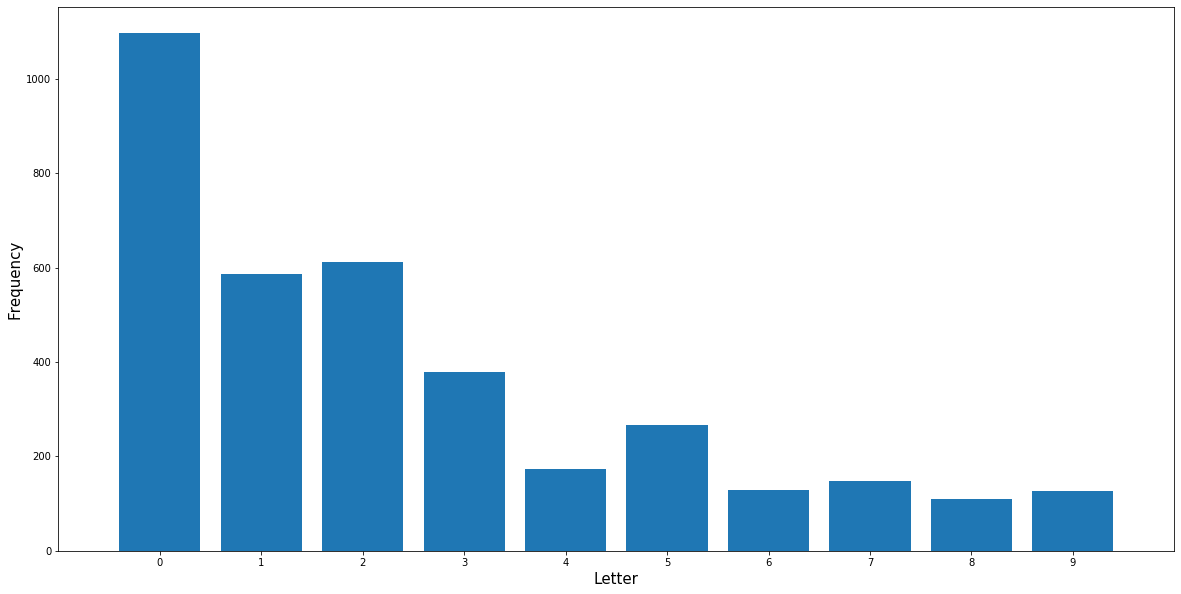

In [60]:
plot_bar(train_numbers_cnt, 'word_train/train_numbers_frequency.jpg')

## VALIDATION SET

In [61]:
_, validation_letters_cnt, _ = words_info('../data/VNOnDB/word/validation_word.csv')

In [62]:
validation_upper_chars_cnt, validation_lower_chars_cnt, validation_numbers_cnt = split_letters_counter(validation_letters_cnt)

In [80]:
sorted(validation_letters_cnt.items(), key=lambda pair: pair[1], reverse=True)

[('n', 7402),
 ('h', 5166),
 ('g', 3784),
 ('c', 3634),
 ('t', 3623),
 ('i', 3496),
 ('u', 1684),
 ('a', 1638),
 ('đ', 1591),
 ('m', 1493),
 ('à', 1311),
 ('ư', 1206),
 ('o', 1131),
 ('r', 1091),
 ('l', 927),
 ('á', 911),
 ('y', 906),
 ('v', 895),
 ('ô', 815),
 ('p', 779),
 ('k', 776),
 ('b', 710),
 ('ế', 554),
 ('ó', 515),
 ('s', 505),
 ('ờ', 501),
 ('ộ', 498),
 ('ạ', 487),
 ('ấ', 471),
 ('ệ', 465),
 ('T', 461),
 ('ê', 452),
 ('ả', 396),
 ('ố', 389),
 ('â', 377),
 ('ớ', 374),
 ('ị', 373),
 ('ề', 332),
 ('0', 331),
 ('ì', 329),
 ('x', 321),
 ('C', 310),
 ('d', 304),
 ('N', 302),
 ('ơ', 280),
 ('ợ', 275),
 ('ậ', 269),
 ('q', 261),
 ('ủ', 261),
 ('e', 259),
 ('ú', 252),
 ('ầ', 246),
 ('1', 245),
 ('ở', 228),
 ('ể', 223),
 ('ứ', 219),
 ('ừ', 210),
 ('ă', 207),
 ('V', 203),
 ('B', 194),
 ('ự', 188),
 ('í', 184),
 ('ã', 181),
 ('ữ', 176),
 ('H', 174),
 ('ồ', 172),
 ('2', 165),
 ('ụ', 147),
 ('P', 145),
 ('ò', 141),
 ('ổ', 140),
 ('ọ', 133),
 ('ù', 126),
 ('ũ', 122),
 ('S', 105),
 ('3', 104)

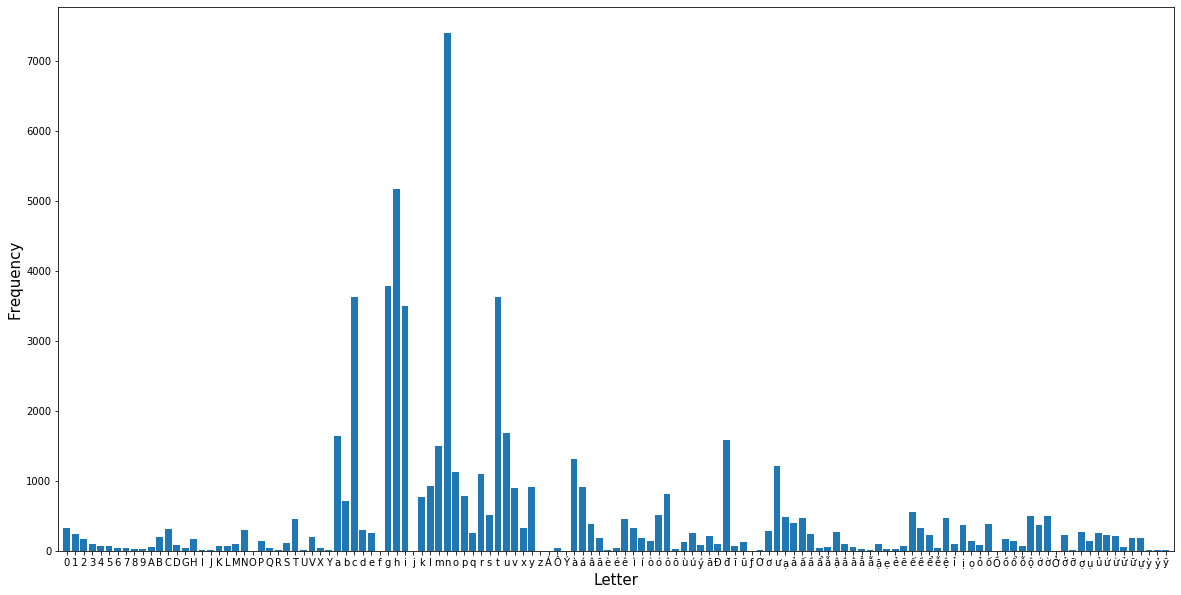

In [63]:
plot_bar(validation_letters_cnt, 'word_validation/validation_letter_frequency.jpg')

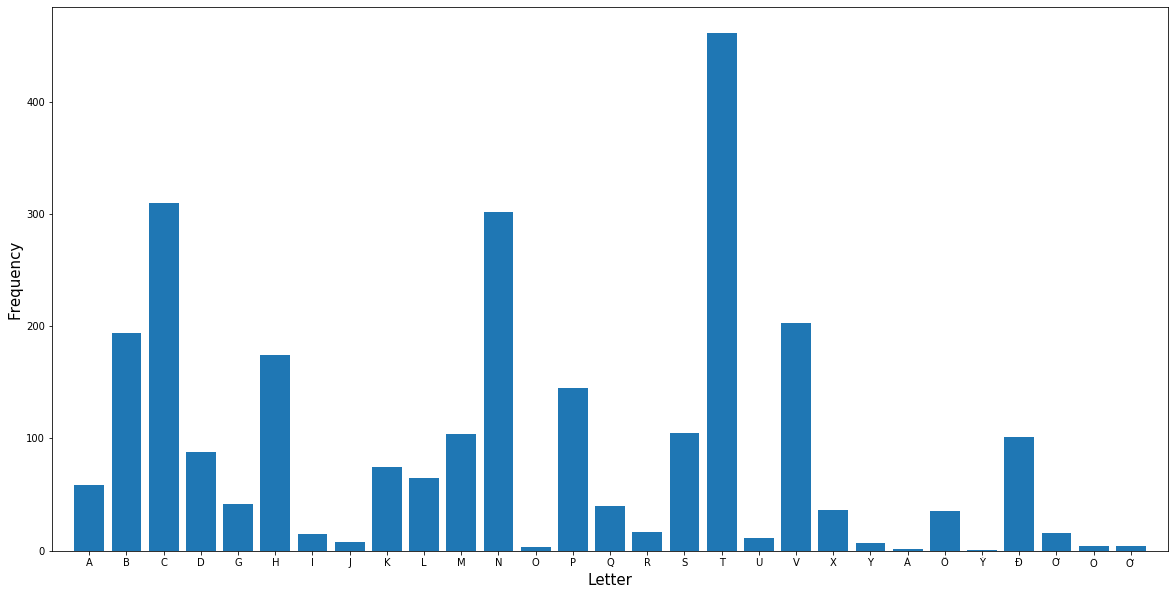

In [64]:
plot_bar(validation_upper_chars_cnt, 'word_validation/validation_upper_characters_frequency.jpg')

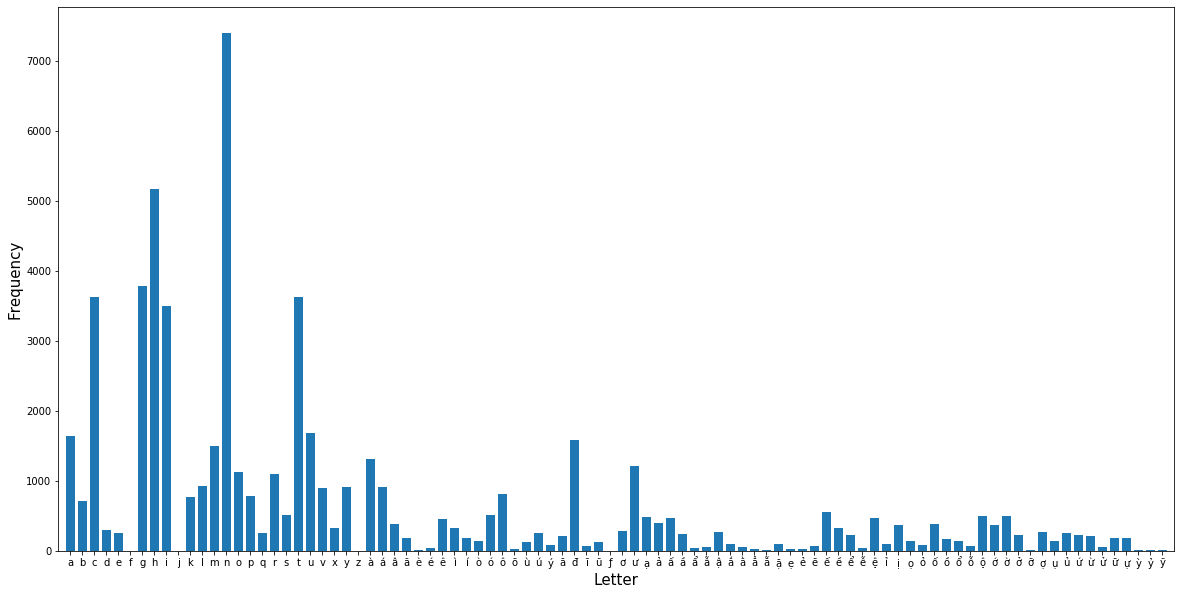

In [65]:
plot_bar(validation_lower_chars_cnt, 'word_validation/validation_lower_characters_frequency.jpg')

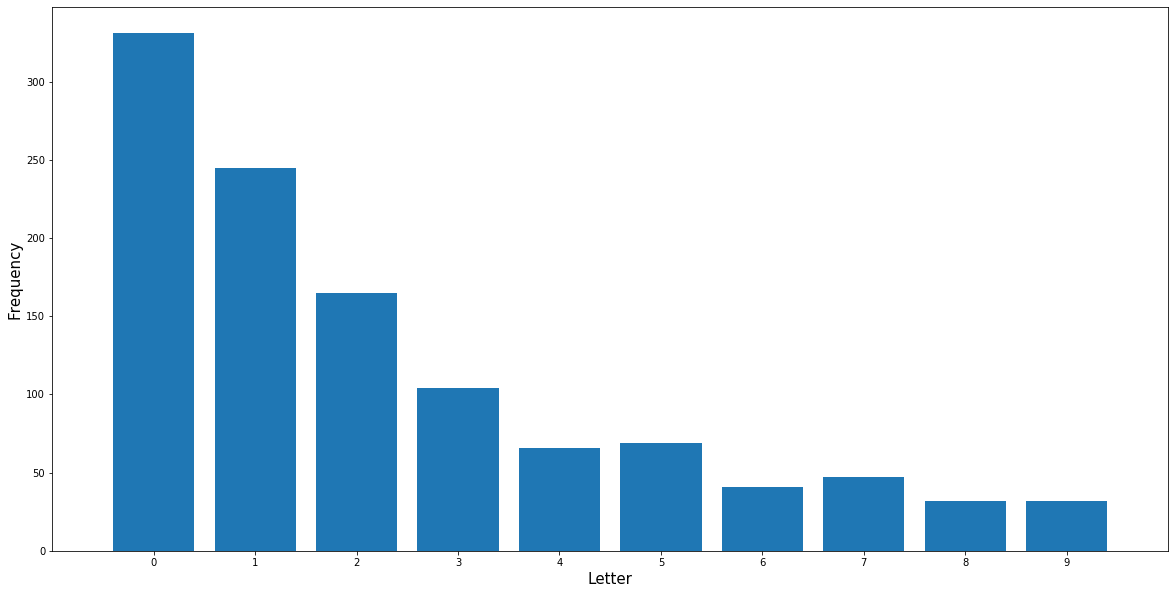

In [66]:
plot_bar(validation_numbers_cnt, 'word_validation/validation_numbers_frequency.jpg')

## TEST SET

In [67]:
_, test_letters_cnt, _ = words_info('../data/VNOnDB/word/test_word.csv')

In [68]:
test_upper_chars_cnt, test_lower_chars_cnt, test_numbers_cnt = split_letters_counter(test_letters_cnt)

In [81]:
sorted(test_letters_cnt.items(), key=lambda pair: pair[1], reverse=True)

[('n', 10000),
 ('h', 7004),
 ('g', 4819),
 ('i', 4809),
 ('t', 4703),
 ('c', 4666),
 ('u', 2314),
 ('a', 2238),
 ('đ', 2155),
 ('m', 1938),
 ('à', 1686),
 ('ư', 1521),
 ('o', 1443),
 ('l', 1333),
 ('r', 1316),
 ('v', 1305),
 ('y', 1239),
 ('á', 1164),
 ('b', 1035),
 ('p', 998),
 ('k', 965),
 ('ô', 960),
 ('s', 683),
 ('ạ', 680),
 ('ế', 668),
 ('ộ', 665),
 ('ê', 645),
 ('ấ', 640),
 ('â', 637),
 ('ệ', 635),
 ('ả', 600),
 ('ờ', 591),
 ('d', 579),
 ('ó', 574),
 ('ố', 568),
 ('T', 567),
 ('ớ', 512),
 ('0', 494),
 ('ề', 463),
 ('ị', 461),
 ('x', 437),
 ('ơ', 437),
 ('ì', 413),
 ('C', 391),
 ('q', 378),
 ('ợ', 368),
 ('ã', 366),
 ('N', 359),
 ('ủ', 347),
 ('ă', 338),
 ('ự', 329),
 ('e', 325),
 ('ể', 320),
 ('ụ', 320),
 ('H', 310),
 ('ậ', 310),
 ('ở', 310),
 ('ầ', 288),
 ('ứ', 274),
 ('ú', 268),
 ('ồ', 258),
 ('1', 242),
 ('ữ', 239),
 ('ò', 236),
 ('2', 235),
 ('B', 229),
 ('V', 216),
 ('ừ', 201),
 ('í', 187),
 ('S', 185),
 ('ổ', 181),
 ('Đ', 176),
 ('P', 168),
 ('ỉ', 163),
 ('ặ', 161),
 ('ọ'

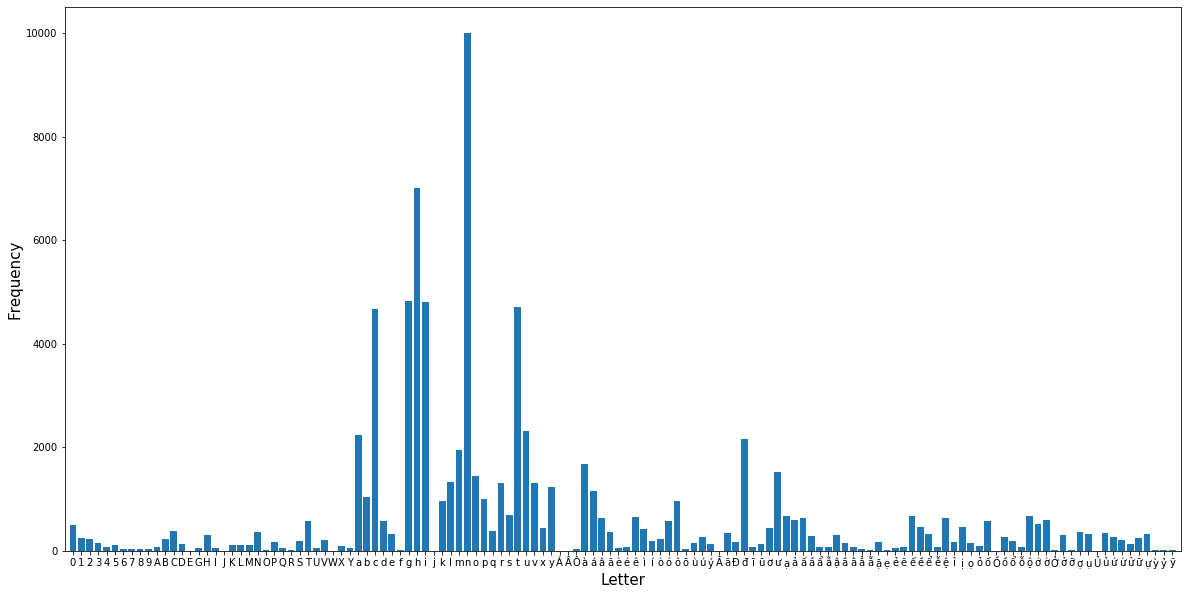

In [69]:
plot_bar(test_letters_cnt, 'word_test/test_letter_frequency.jpg')

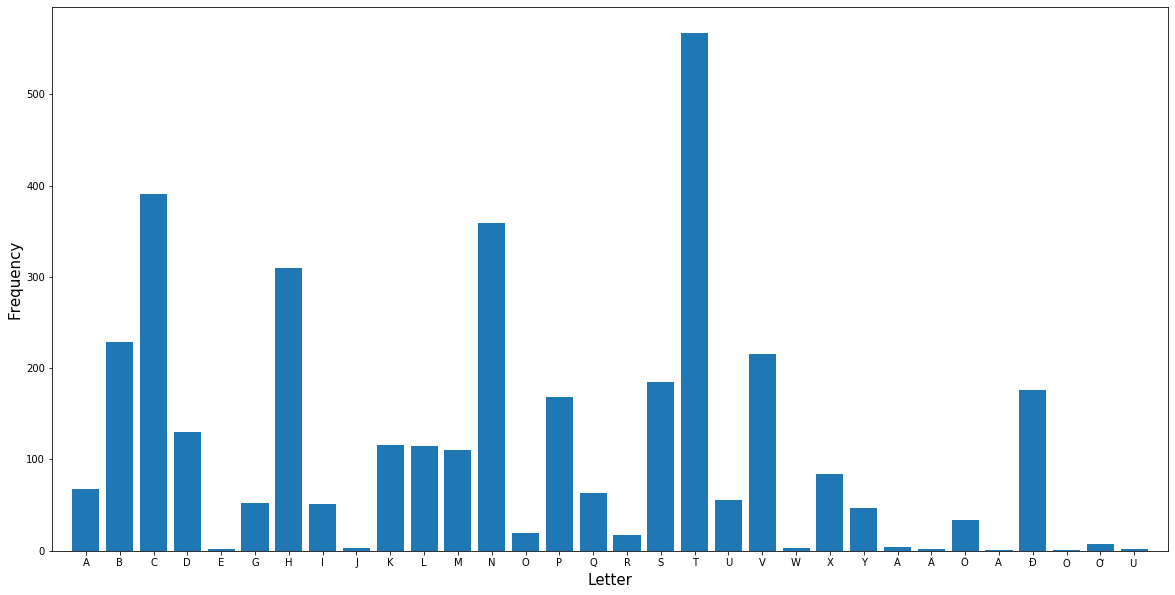

In [70]:
plot_bar(test_upper_chars_cnt, 'word_test/test_upper_characters_frequency.jpg')

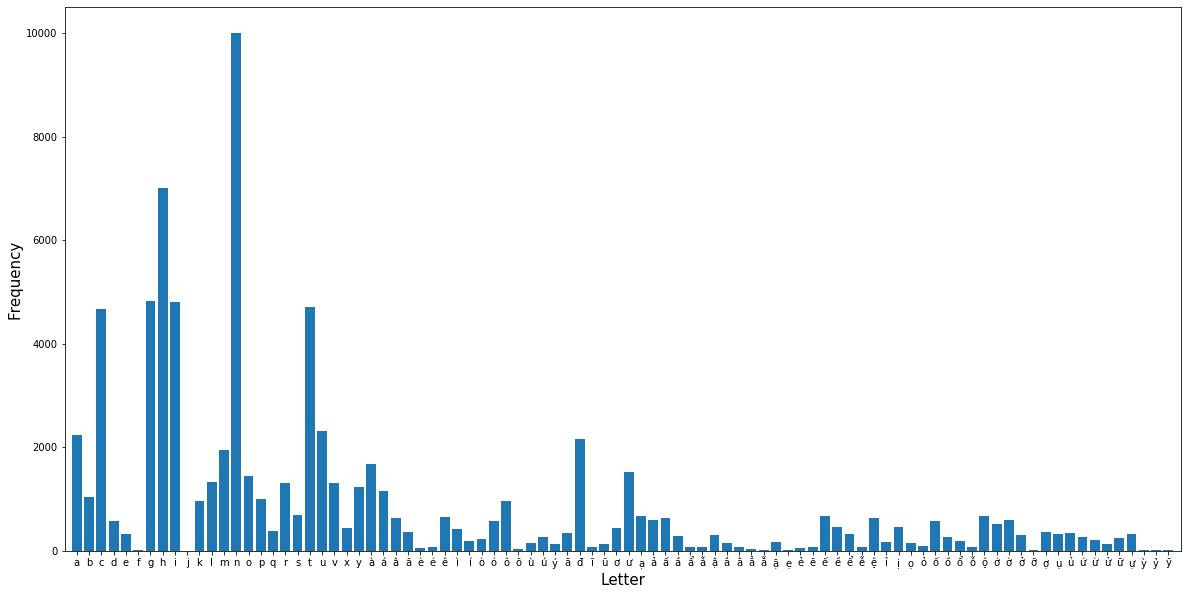

In [71]:
plot_bar(test_lower_chars_cnt, 'word_test/test_lower_characters_frequency.jpg')

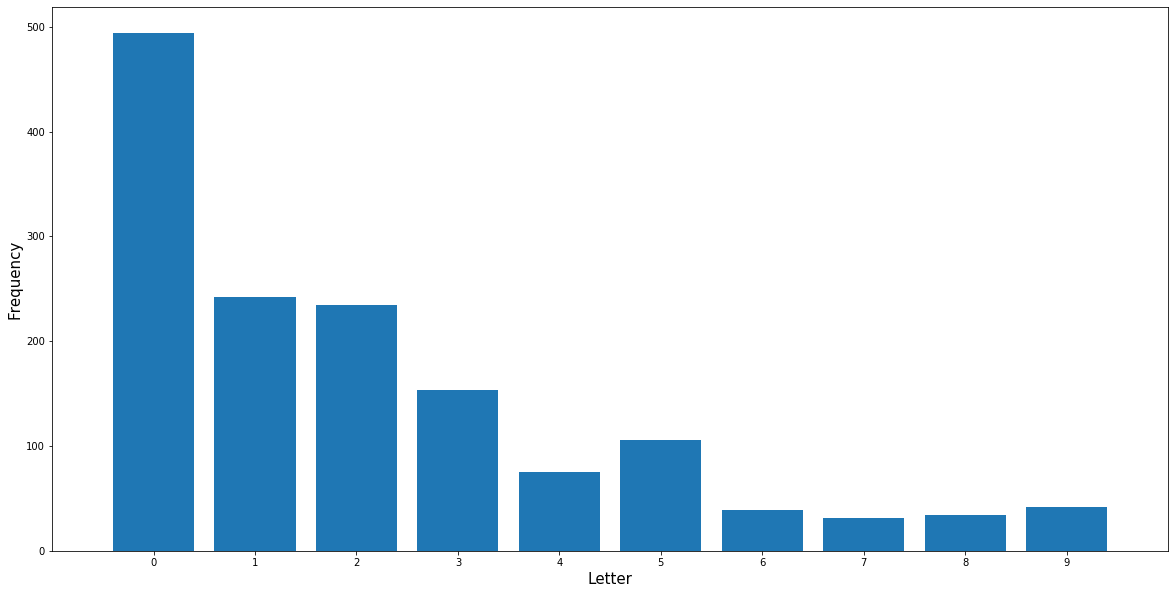

In [72]:
plot_bar(test_numbers_cnt, 'word_test/test_numbers_frequency.jpg')

# MISSING

In [73]:
print(f'Number of letters in all: {len(all_letters_cnt)}')
print(f'Number of letters in train-set: {len(train_letters_cnt)}')
print(f'Number of letters in validation-set: {len(validation_letters_cnt)}')
print(f'Number of letters in test-set: {len(test_letters_cnt)}')

Number of letters in all: 147
Number of letters in train-set: 144
Number of letters in validation-set: 131
Number of letters in test-set: 132


In [75]:
# OOV
print(f'validation-set OOV: {validation_letters_cnt.keys() - train_letters_cnt.keys()}')
print(f'test-set OOV: {test_letters_cnt.keys() - train_letters_cnt}')

validation-set OOV: {'ƒ', 'Ý'}
test-set OOV: {'Ă'}
